## Asistente de Afiliaciones — Texto + Imagen

Este proyecto implementa un **asistente conversacional** para agentes de Afiliaciones (IOMA) usando la **versión v6** de mi prompt optimizado.  
El asistente responde **exclusivamente en JSON**, toma contexto de una **base de conocimiento** (CSV) y genera una **imagen institucional** según el tema de la consulta (p. ej., “afiliación de recién nacido/a”, “estudiante”, “conviviente”), con **cache** de imágenes para ahorrar costos.

**Qué incluye:**
- *System prompt v6* (reglas fijas, JSON estricto).
- Búsqueda de **FAQ** por relevancia (tokens, títulos, contenido, palabras clave).
- **Chat con memoria** (historial) y función `reset_history()`.
- **Imágenes** con paleta IOMA (genera a 1024×1024 y muestra miniatura 256×256; reutiliza desde `imgs/`).
- **UI con ipywidgets**: banner de bienvenida, texto a la izquierda e imagen a la derecha.
- **Snapshot para GitHub**: genera una vista estática (banner + JSON + imagen) que se ve bien en GitHub.

> **Modelos usados:** `gpt-4o-` (texto) y `dall-e-3` (imágenes, con fallback a `gpt-image-1`).  
> **Requisitos:** `OPENAI_API_KEY` en `.env` o variable de entorno y el CSV en `../data/base_conocimiento_afiliaciones_clean.csv` (ajustable).


In [1]:
import os, re, json
import pandas as pd
from textwrap import dedent
from dotenv import load_dotenv
from openai import OpenAI
import base64, requests, unicodedata
from io import BytesIO
from PIL import Image
from pathlib import Path

load_dotenv()  # toma OPENAI_API_KEY del .env si existe


True

### Carga base de conocimiento (CSV)

Carga el CSV con normativa/FAQs, filtra por `estado ∈ {"vigente","en revisión"}` y normaliza columnas clave.  
Ajustá `CSV_PATH` si tu ruta es distinta. Si el archivo no existe, el notebook avisa con `FileNotFoundError`.


In [2]:
from pathlib import Path

# 👇 Ajustá la ruta si hace falta
CSV_PATH = "../data/base_conocimiento_afiliaciones_clean.csv"

p = Path(CSV_PATH)
if not p.exists():
    raise FileNotFoundError(f"CSV no encontrado: {p.resolve()} — ajustá CSV_PATH.")

df = pd.read_csv(p, dtype=str, keep_default_na=False)
df = df[df["estado"].str.lower().isin(["vigente","en revisión"])].copy()

for col in ["id","titulo","contenido","respuesta_validada","palabras_clave"]:
    if col in df.columns:
        df[col] = df[col].fillna("").astype(str)

print("Filas cargadas:", len(df))


Filas cargadas: 18


### Helpers de búsqueda (tokens, ranking, top-1)

En este bloque implemento un buscador **ligero** para elegir la FAQ más relevante a partir del texto de la consulta. Opté por una heurística simple en vez de embeddings para mantener el costo en cero y la latencia mínima.

**Qué hago paso a paso:**
1. **Normalización y tokenización.** Paso el texto a minúsculas y separo por caracteres no alfanuméricos, contemplando acentos (`áéíóúñü`) para español. Esto me evita depender de stopwords externas y funciona bien para títulos cortos.
2. **Puntaje por campo (ponderado).** Calculo un score por coincidencias de tokens entre la consulta y cada fila de la tabla:
   - `+3` por coincidencias con **palabras_clave** (curadas a mano).
   - `+2` en el **título** (alta señal).
   - `+1` en el **contenido** (cobertura más laxa).
3. **Selección top-1.** Me quedo con la fila de mayor puntaje; si nadie supera 0, no selecciono FAQ y dejo la **BASE vacía** (la v6 ya define qué hacer en ese caso).

**Por qué esta heurística:**
- Es **barata** (no llama a modelo para recuperar).
- Es **predecible** y fácil de auditar (un puntaje por campo).
- Me permite **priorizar** rápidamente entradas bien etiquetadas.

**Limitaciones y mejoras posibles:**
- No hace stemming ni sinónimos; variantes como “recien nacido” vs. “recién nacido” las manejo luego con reglas en imágenes o ampliando palabras clave.
- Se podría migrar a un **BM25** o a **embeddings** para mejorar recall; por ahora priorizo costo y simplicidad.


In [3]:
def dividir_en_tokens(texto: str):
    texto = (texto or "").lower()
    return [t for t in re.split(r"[^a-záéíóúñü0-9]+", texto) if t]

def calcular_relevancia(tokens_consulta, fila):
    puntaje = 0
    puntaje += 3 * len(set(tokens_consulta) & set(dividir_en_tokens(fila.get("palabras_clave",""))))
    puntaje += 2 * len(set(tokens_consulta) & set(dividir_en_tokens(fila.get("titulo",""))))
    puntaje += 1 * len(set(tokens_consulta) & set(dividir_en_tokens(fila.get("contenido",""))))
    return puntaje

def buscar_faq(consulta: str, tabla: pd.DataFrame):
    toks = dividir_en_tokens(consulta)
    puntuadas = [(calcular_relevancia(toks, fila), idx) for idx, fila in tabla.iterrows()]
    puntuadas = [(p,i) for p,i in puntuadas if p>0]
    if not puntuadas:
        return None
    puntuadas.sort(reverse=True)
    return tabla.loc[puntuadas[0][1]]


## System Prompt fijo + contexto por turno

- **`SYSTEM_PROMPT_V6`**: reglas permanentes (JSON estricto, fuentes y limitaciones).
- **`build_context_v6`**: para *cada pregunta*, construye el bloque con `Pregunta` y `<<BASE>> ... <<FIN_BASE>>` (compactada).  
Si no hay BASE, la respuesta debe indicar “No consta en la normativa adjunta” cuando corresponda.


In [4]:
def compactar_texto(s: str, max_chars=800):
    s = re.sub(r"\s+", " ", (s or "")).strip()
    return s[:max_chars]

# a) System prompt fijo (v6)
SYSTEM_PROMPT_V6 = dedent("""
Rol: Asistente de Afiliaciones de IOMA. Público: agentes. Tono: institucional.

Instrucciones:
- "checklist": SOLO de <<BASE>>. Si falta dato: "No consta en la normativa adjunta".
- "terminos_clave" y "objetivo_y_buenas_practicas": podés usar conocimiento externo.
- Responder SOLO con JSON válido.

Formato:
{
  "checklist": ["...", "..."],
  "terminos_clave": ["Término: definición breve", "...", "..."],
  "objetivo_y_buenas_practicas": ["Buena práctica: detalle breve", "...", "..."],
  "cierre": "Fuente: base de conocimiento vigente"
}
""").strip()

# b) Contexto dinámico por turno (Pregunta + BASE)
def build_context_v6(fila, pregunta: str):
    if fila is None:
        base = ""
        idtitulo = "(ninguna)"
    else:
        base = (fila.get("respuesta_validada") or 
                fila.get("contenido") or 
                fila.get("titulo","")).strip()
        base = compactar_texto(base, 800)
        idtitulo = f"{fila.get('id','(sin id)')} – {fila.get('titulo','(sin título)')}"
    payload = dedent(f'''
    Pregunta: "{pregunta}"

    <<BASE>>
    {base}
    <<FIN_BASE>>
    ''').strip()
    return payload, idtitulo


### Cliente OpenAI + modelo

Inicializa el cliente con `OPENAI_API_KEY`.  
Modelo de texto por defecto: **`gpt-4o`** (Se puede cambiar a `gpt-4o-mini` si esta disponible).


In [5]:
api_key = os.getenv("OPENAI_API_KEY")
assert api_key, "Falta OPENAI_API_KEY (definila en .env o variable de entorno)."

client = OpenAI(api_key=api_key)
MODEL = "gpt-4o"  
print("Cliente listo, modelo:", MODEL)


Cliente listo, modelo: gpt-4o


### Imágenes: paleta IOMA, carpeta y utilidades

Acá defino el **branding visual** y la **infra mínima** para manejar imágenes:

- **Paleta IOMA.** Centralizo los colores institucionales (teal, púrpura, magenta, blanco y gris). Los reutilizo en prompts y en la UI para un look consistente.
- **Carpeta `imgs/`.** Creo (si no existe) un directorio local donde cacheo las imágenes generadas por tema. Esto me permite reutilizarlas sin volver a gastar créditos.
- **Utilidades.**
  - `slugify()`: convierte el tema a un nombre de archivo seguro (ASCII, guiones).
  - `resize_to()`: genero una **miniatura 256×256** para la UI, partiendo del PNG 1024×1024 original.
  
**Decisiones de diseño:**
- **1024×1024** para generación: la imagen sale más nítida y luego hago *downscale* a 256×256 para mostrar rápido en el chat.
- El **cache** reduce costos y acelera la respuesta en repreguntas sobre el mismo tema.


In [6]:
# Paleta IOMA
PALETA_IOMA = {
    "teal":    "#2D8DA6",
    "purpura": "#6A5AAE",
    "magenta": "#C4286F",
    "blanco":  "#FFFFFF",
    "gris":    "#3C3C3C",
}

IMGS_DIR = Path("imgs")
IMGS_DIR.mkdir(parents=True, exist_ok=True)

def slugify(s: str) -> str:
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = re.sub(r"[^a-zA-Z0-9]+", "-", s).strip("-").lower()
    return s or "imagen"

def resize_to(path_in: Path, path_out: Path, size=(256, 256)):
    im = Image.open(path_in).convert("RGB")
    im = im.resize(size, Image.LANCZOS)
    im.save(path_out, format="PNG")
    return path_out


### Imágenes: prompt visual y generación con cache 

En este bloque armo el **prompt visual** y la mecánica de **generación con cache**:

- **Prompt visual.** Describo una ilustración institucional, minimalista y cálida, con **degradado** en la paleta IOMA y un **halo** que refuerza el foco del tema. No incluyo textos en la imagen para evitar ruido y problemas de legibilidad.
- **Modelos.** Uso `dall-e-3` y si falla hago **fallback** a `gpt-image-1`. Esto me da robustez sin frenar el flujo.
- **Estrategia de cache.**
  1. Si ya existe la miniatura `tema_256x256.png`, la uso tal cual.
  2. Si solo existe el original `tema_1024.png`, genero la mini 256×256 en el momento.
  3. Si no existe nada, **genero 1024**, guardo, y luego creo la **256**.

**Beneficios:**
- **Costo controlado:** ante temas repetidos no vuelvo a pedir imágenes.
- **Rendimiento:** el *downscale* local es instantáneo.
- **Consistencia visual:** el prompt forzado con colores y estilo mantiene una estética homogénea en todo el asistente.

**Notas operativas:**
- El nombre de archivo deriva del **tema** (ej.: `afiliacion-de-recien-nacido-a_1024.png`).
- Si un día cambio la paleta o el estilo, basta actualizar el prompt base para que las nuevas imágenes sigan el branding.


In [ ]:
IMAGES_MODEL_PRIMARY   = "dall-e-3"
IMAGES_MODEL_FALLBACK  = "gpt-image-1"

def build_prompt_imagen(tema: str) -> str:
    return f"""
Ilustración institucional clara y elegante sobre **{tema}** como figura o escena central.
Fondo con degradado armónico de la paleta IOMA 
(teal {PALETA_IOMA['teal']}, púrpura {PALETA_IOMA['purpura']}, magenta {PALETA_IOMA['magenta']}).
Destacar el sujeto principal con **un recuadro, panel o marco rectangular sutil**,
o con bloques geométricos detrás que sugieran orden y estructura.
Evitar por completo símbolos o estética religiosa.
Estilo minimalista, moderno y cálido, sin texto en la imagen. Composición limpia y corporativa.
"""




def _generate_image_bytes(model: str, prompt_text: str, size: str = "1024x1024"):
    resp = client.images.generate(model=model, prompt=prompt_text, n=1, size=size)
    # Intentar URL
    try:
        url = resp.data[0].url
        if url:
            return requests.get(url, timeout=120).content
    except Exception:
        pass
    # Intentar b64_json
    try:
        b64 = resp.data[0].b64_json
        if b64:
            return base64.b64decode(b64)
    except Exception:
        pass
    raise RuntimeError("No se pudo obtener la imagen (ni url ni b64_json).")

def get_or_create_image_for_theme(tema: str,
                                  size_generate="1024x1024",
                                  size_display=(256, 256)) -> Path:
    slug = slugify(tema)
    p_full = IMGS_DIR / f"{slug}_1024.png"
    p_disp = IMGS_DIR / f"{slug}_{size_display[0]}x{size_display[1]}.png"

    if p_disp.exists():
        return p_disp
    if p_full.exists():
        return resize_to(p_full, p_disp, size=size_display)

    prompt_text = build_prompt_imagen(tema)
    try:
        img_bytes = _generate_image_bytes(IMAGES_MODEL_PRIMARY, prompt_text, size_generate)
    except Exception:
        img_bytes = _generate_image_bytes(IMAGES_MODEL_FALLBACK, prompt_text, size_generate)

    Image.open(BytesIO(img_bytes)).convert("RGB").save(p_full)
    resize_to(p_full, p_disp, size=size_display)
    return p_disp


### Imágenes: inferencia de tema + override `tema: …`

Acá decido **qué tema** ilustro en cada respuesta:

- **Reglas por regex.** Busco palabras clave en la **consulta** y el **título** de la FAQ:  
  ejemplos: `reci(é)n nacid*`, `estudiante`, `conviviente`, `cónyuge`, `monotribut*`, etc.  
  Esto cubre los casos más comunes sin costo adicional.
- **Orden de precedencia.**
  1. Si el usuario escribe `tema: algo`, **respeto ese override**.
  2. Si hay FAQ seleccionada, uso su **título** para dar contexto.
  3. Si nada matchea, caigo a un **fallback** genérico: “afiliaciones IOMA”.
- **Cache por tema.** Una vez resuelto el tema, reutilizo/creo la imagen correspondiente (ver Bloque B).

**Por qué así:**
- El “override” me permite **control total** en demos o casos borde.
- Las **regex** son suficientes para este dominio acotado; si el alcance crece, puedo pasar a un clasificador liviano o a un mapeo de sinónimos más rico.

**Mejoras futuras:**
- Lista de **sinónimos** por categoría (ej.: “neonato”, “nacimiento”, “alta del bebé” → recién nacido/a).
- Priorizar el **estado** de la FAQ (si hubiera varias candidatas) para elegir el tema más actualizado.


In [8]:
def infer_tema_imagen(consulta: str, fila_sel) -> str:
    # override manual si el usuario escribe 'tema: ...'
    m = re.search(r"tema\s*:\s*([^\n\r]+)", consulta, flags=re.IGNORECASE)
    if m:
        override = m.group(1).strip()
        if override:
            return override

    cand = (fila_sel.get("titulo","") if isinstance(fila_sel, dict) else (fila_sel["titulo"] if fila_sel is not None and "titulo" in fila_sel else "")) or ""
    texto_ref = f"{consulta} {cand}".lower()

    rules = [
        (r"reci[eé]n\s*nacid[oa]", "afiliación de recién nacido/a"),
        (r"recien\s*nac", "afiliación de recién nacido/a"),
        (r"estudiante", "afiliación de estudiante"),
        (r"conviviente", "afiliación de conviviente"),
        (r"c[oó]nyuge|conyuge", "afiliación de cónyuge"),
        (r"monotribut", "afiliación de monotributista"),
        (r"padre|madre|progenitor", "afiliación por vínculo familiar"),
    ]
    for pat, tema in rules:
        if re.search(pat, texto_ref):
            return tema

    return cand.strip() or "afiliaciones IOMA"


### Chat con memoria

- Mantiene `chat_history` (incluye `SYSTEM_PROMPT_V6`) y guarda metadatos en `last_meta` (FAQ y tema detectado).
- `chat(consulta)`: busca FAQ, arma contexto v6, llama al modelo y retorna **JSON en texto**.
- `reset_history()`: reinicia la conversación sin perder el *system prompt*.


In [9]:
# Historial con v6
chat_history = [{"role": "system", "content": SYSTEM_PROMPT_V6}]
last_meta = {"fila_sel": None, "faq_idtitulo": None, "tema": None}

def reset_history():
    global chat_history, last_meta
    chat_history = [{"role": "system", "content": SYSTEM_PROMPT_V6}]
    last_meta = {"fila_sel": None, "faq_idtitulo": None, "tema": None}
    return "Historial reiniciado (v6 cargada)."

def chat(consulta: str, temperature: float = 0.2, max_tokens: int = 400):
    global last_meta

    fila_sel = buscar_faq(consulta, df)
    contexto, idtitulo = build_context_v6(fila_sel, consulta)

    chat_history.append({"role": "user", "content": contexto})
    resp = client.chat.completions.create(
        model=MODEL,
        messages=chat_history,
        temperature=temperature,
        max_tokens=max_tokens,
    )
    assistant_msg = resp.choices[0].message.content
    chat_history.append({"role": "assistant", "content": assistant_msg})

    tema = infer_tema_imagen(consulta, fila_sel.to_dict() if fila_sel is not None else {})
    last_meta = {
        "fila_sel": (fila_sel.to_dict() if fila_sel is not None else None),
        "faq_idtitulo": idtitulo,
        "tema": tema
    }
    return assistant_msg


### UI con ipywidgets (banner, colores IOMA, texto + imagen)

En este bloque construyo la **interfaz de chat** directamente en la notebook con `ipywidgets`, cuidando el **branding IOMA** y la legibilidad del JSON. La UI queda así:

- **Banner de bienvenida** con degradé y colores institucionales (teal–púrpura–magenta).
- **Cuadro de texto** para escribir la consulta y botones **Enviar** / **Reset historial**.
- **Panel de salida** que muestra cada turno con:
  - **Izquierda:** la respuesta del asistente en un bloque `<pre>` (JSON puro), con tipografía legible, borde teal y fondo blanco.
  - **Derecha:** una **miniatura 256×256** generada/cargada según el **tema** detectado (p. ej., “afiliación de recién nacido/a”), centrada verticalmente.
  
**Cómo funciona internamente:**
- Al hacer click en **Enviar**, la UI llama a `chat(mensaje)`.  
  Esa función:
  1) busca la FAQ más relevante,  
  2) arma el contexto v6 (Pregunta + `<<BASE>>`),  
  3) consulta el modelo,  
  4) infiere el **tema** para la imagen y guarda metadatos en `last_meta`.
- Con el **tema**, la UI pide la miniatura a `get_or_create_image_for_theme(...)`.  
  Si ya existe en `imgs/`, la reutiliza (cache); si no, genera el **1024×1024**, lo guarda y crea la mini **256×256**.

**Personalizaciones útiles:**
- Puedo forzar el tema escribiendo `tema: estudiante` (o cualquier otro) dentro de mi mensaje.  
- Puedo ajustar el tamaño de la mini (por ejemplo, 192×192) si quiero más compacidad visual.
- El botón **Reset historial** limpia el diálogo pero deja cargado el *system prompt* v6.

**Requisitos y consideraciones:**
- Para ver los widgets en VS Code necesito las extensiones **Jupyter** + **Notebook Renderers** y el paquete `ipywidgets` instalado.
- En **GitHub** los widgets **no se renderizan**; para eso genero un **snapshot estático** en el bloque de abajo. Igualmente adjunto una imagen de muestra con como se ve la ejecucion


In [10]:
# UI con estilos IOMA + banner + respuesta coloreada + imagen centrada
try:
    import ipywidgets as widgets
    from IPython.display import display
    from pathlib import Path
    import html

    banner = widgets.HTML(
        value=f"""
        <div style="
            padding:14px 16px;
            border-radius:12px;
            background: linear-gradient(90deg, {PALETA_IOMA['teal']}22, {PALETA_IOMA['purpura']}22, {PALETA_IOMA['magenta']}22);
            border:1px solid {PALETA_IOMA['teal']};
            ">
          <div style="font-weight:700; font-size:16px; color:{PALETA_IOMA['teal']};">
            Bienvenido/a al Asistente de Afiliaciones
          </div>
          <div style="font-size:12.5px; color:{PALETA_IOMA['gris']};">
            Consultá requisitos, documentación y buenas prácticas. Las respuestas siguen la BASE vigente y se devuelven en JSON.
          </div>
        </div>
        """
    )

    input_box = widgets.Textarea(
        value='',
        placeholder='Ej: recién nacido / estudiante / conviviente (podés usar "tema: estudiante" para forzar)',
        description='Usuario:',
        disabled=False,
        layout=widgets.Layout(width='100%', height='80px')
    )
    send_btn = widgets.Button(description='Enviar')
    reset_btn = widgets.Button(description='Reset historial')

    out = widgets.Output(layout=widgets.Layout(
        border=f'2px solid {PALETA_IOMA["teal"]}',
        padding='8px',
        max_height='520px',
        overflow='auto'
    ))

    try:
        send_btn.style.button_color  = PALETA_IOMA["teal"]
        reset_btn.style.button_color = PALETA_IOMA["magenta"]
    except Exception:
        send_btn.button_style  = 'info'
        reset_btn.button_style = 'warning'

    def on_send_clicked(_):
        with out:
            user_text = input_box.value.strip()
            if not user_text:
                print("Escribí un mensaje primero.")
                return

            display(widgets.HTML(
                f"<div style='margin-top:10px; font-weight:600; color:{PALETA_IOMA['purpura']};'>Usuario: {html.escape(user_text)}</div>"
            ))

            ans = chat(user_text)

            faq_label = html.escape(last_meta.get('faq_idtitulo','(ninguna)') or '(ninguna)')
            ans_html = html.escape(ans)
            left_panel = widgets.HTML(
                value=f"""
                <div style="font-family: Segoe UI, Roboto, Arial, sans-serif; color:{PALETA_IOMA['gris']}; line-height:1.45;">
                  <div style="font-size:12px; opacity:.8;">FAQ seleccionada: {faq_label}</div>
                  <div style="font-weight:700; margin:6px 0 8px 0; color:{PALETA_IOMA['teal']};">Asistente</div>
                  <pre style="
                      white-space:pre-wrap;
                      background:#FFFFFF;
                      color:{PALETA_IOMA['gris']};
                      border:1px solid {PALETA_IOMA['teal']};
                      border-radius:10px;
                      padding:12px;
                      box-shadow: 0 1px 4px rgba(0,0,0,.06);
                      ">{ans_html}</pre>
                </div>
                """
            )

            try:
                tema = last_meta.get("tema") or "afiliaciones IOMA"
                path_256 = get_or_create_image_for_theme(
                    tema, size_generate="1024x1024", size_display=(256, 256)
                )
                img_bytes = Path(path_256).read_bytes()
                img_widget = widgets.Image(value=img_bytes, format='png', width=256, height=256)
                caption = widgets.HTML(
                    f"<div style='text-align:center;color:{PALETA_IOMA['gris']};font-size:12px;'>Imagen: {html.escape(tema)}</div>"
                )
                right_panel = widgets.VBox(
                    [img_widget, caption],
                    layout=widgets.Layout(
                        align_items='center',
                        width='30%',
                        align_self='center'   # centra verticalmente
                    )
                )
            except Exception as e:
                right_panel = widgets.HTML(
                    f"<div style='color:{PALETA_IOMA['magenta']};'>No se pudo mostrar la imagen ({html.escape(str(e))}).</div>"
                )

            display(
                widgets.HBox(
                    [
                        widgets.VBox([left_panel],  layout=widgets.Layout(width='70%')),
                        right_panel
                    ],
                    layout=widgets.Layout(width='100%', align_items='center')
                )
            )

            input_box.value = ''

    def on_reset_clicked(_):
        with out:
            print(reset_history())

    send_btn.on_click(on_send_clicked)
    reset_btn.on_click(on_reset_clicked)

    display(banner, input_box, widgets.HBox([send_btn, reset_btn]), out)

except Exception as e:
    print("UI opcional no disponible:", e)


HTML(value='\n        <div style="\n            padding:14px 16px;\n            border-radius:12px;\n         …

Textarea(value='', description='Usuario:', layout=Layout(height='80px', width='100%'), placeholder='Ej: recién…

Output(layout=Layout(border_bottom='2px solid #2D8DA6', border_left='2px solid #2D8DA6', border_right='2px sol…

### Snapshot estático para GitHub (banner + JSON + imagen)

GitHub **no** ejecuta widgets, así que si subo la notebook tal cual, el visor va a mostrar objetos (`HTML(...)`, `Textarea(...)`) en lugar de la UI.  
Para resolverlo, agrego una celda que crea un **snapshot estático** con todo lo necesario:

- **Banner** en HTML (versión no-widget, renderizable por GitHub).
- **FAQ seleccionada** (texto).
- **Respuesta del asistente** en un bloque ```json (solo lectura).
- **Imagen 256×256** embebida (quedará dentro del `.ipynb`, visible en GitHub).

**Cómo lo uso:**
1. Primero **chateo** con la UI hasta obtener una respuesta e imagen que me guste.  
2. Luego ejecuto `snapshot_github()` (o `snapshot_github("recién nacido")` si quiero forzar una nueva).  
3. **Guardo** la notebook con los outputs (no limpiar salidas) y la subo al repo.

**Tips importantes:**
- El snapshot embebe la miniatura (base64), por lo que el `.ipynb` puede crecer un poco; si necesito varias capturas, conviene limitar la cantidad de snapshots por notebook.
- Si al ejecutar el snapshot no hay respuesta previa, puedo pasar el mensaje directamente: `snapshot_github("conviviente")`.

Con este flujo, en GitHub se ve **exactamente**: el banner, la FAQ, el JSON y la imagen, sin depender de widgets.

ℹ️ **Nota:**  
Esta funcionalidad de `snapshot_github()` la implementé únicamente para efectos de la entrega, 
con el objetivo de que el resultado final (banner + JSON + imagen) se visualice correctamente en el 
repositorio y los profesores puedan evaluarlo sin depender de widgets interactivos.



In [11]:
from IPython.display import display, HTML, Markdown, Image as IPyImage
from pathlib import Path
import html, json, re as _re

def snapshot_github(mensaje: str | None = None, incluir_banner: bool = True):
    # 1) Obtener respuesta y meta
    if mensaje:
        ans = chat(mensaje)  # actualiza last_meta
    else:
        ans = ""
        for item in reversed(chat_history):
            if item["role"] == "assistant":
                ans = item["content"]; break
        if not ans:
            raise RuntimeError("No hay respuesta previa. Pasá un 'mensaje' a snapshot_github().")

    faq_label = html.escape(last_meta.get("faq_idtitulo", "(ninguna)") or "(ninguna)")
    tema = last_meta.get("tema") or "afiliaciones IOMA"
    path_256 = get_or_create_image_for_theme(tema, size_generate="1024x1024", size_display=(256, 256))

    # 2) Banner ESTÁTICO (no widget) -> esto sí lo renderiza GitHub
    if incluir_banner:
        display(HTML(f"""
        <div style="
            padding:14px 16px;
            border-radius:12px;
            background: linear-gradient(90deg, {PALETA_IOMA['teal']}22, {PALETA_IOMA['purpura']}22, {PALETA_IOMA['magenta']}22);
            border:1px solid {PALETA_IOMA['teal']};
            font-family: Segoe UI, Roboto, Arial, sans-serif;
            ">
          <div style="font-weight:700; font-size:16px; color:{PALETA_IOMA['teal']};">
            Bienvenido/a al Asistente de Afiliaciones
          </div>
          <div style="font-size:12.5px; color:{PALETA_IOMA['gris']};">
            Consultá requisitos, documentación y buenas prácticas. Las respuestas siguen la BASE vigente y se devuelven en JSON.
          </div>
        </div>
        """))

    # 3) FAQ + respuesta en bloque + imagen
    display(Markdown(f"**FAQ seleccionada:** {faq_label}"))
    display(Markdown("**Asistente**"))
    display(Markdown(f"```json\n{ans}\n```"))
    display(IPyImage(filename=str(path_256)))


**FAQ seleccionada:** faq_004 – Afiliación de recién nacido/a

**Asistente**

```json
```json
{
  "checklist": [
    "Credencial o DNI del afiliado/a titular",
    "DNI del menor o constancia de parto donde figuren madre y padre",
    "Ficha de afiliación cumplimentada (no certificada, solo la parte del afiliado)",
    "Último recibo de haberes",
    "CUIL si lo posee",
    "Certificado de nacimiento del menor"
  ],
  "terminos_clave": [
    "Afiliado titular: persona que tiene la titularidad de la afiliación",
    "CUIL: Código Único de Identificación Laboral, necesario para trámites oficiales",
    "Ficha de afiliación: documento que se completa para solicitar la afiliación"
  ],
  "objetivo_y_buenas_practicas": [
    "Buena práctica: Presentar toda la documentación requerida para evitar demoras en la afiliación",
    "Buena práctica: Actualizar el DNI del recién nacido en el sistema una vez obtenido",
    "Objetivo: Facilitar la incorporación del recién nacido al sistema de salud del afiliado titular"
  ],
  "cierre": "Fuente: base de conocimiento vigente"
}
```
```

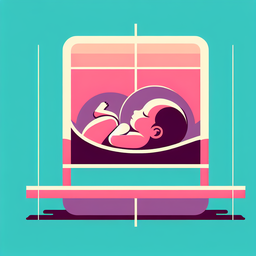

In [13]:
snapshot_github() 